# Variational AutoEncoder to Learn Emoji Distribution

Data taken from https://github.com/googlefonts/noto-emoji/tree/main/png/128

In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [2]:
import torch
import numpy as np
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import transforms
import torch.nn.functional as F
import torch.nn.init as init
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import math
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.manifold import TSNE
import torchvision.transforms as T


## Hyperparameters

In [3]:
BATCH_SIZE = 128
LATENT_DIM = 6
LAMBDA_Z = 1e-4
LAMBDA_PAIR = 1e-4

## Dataset Preprocessing and Preparation

In [ ]:
class EmojiDataset(Dataset):
    def __init__(self, root, small_sample = False):
        self.root = root
        if not small_sample:
            self.files = [f for f in os.listdir(root) if f.endswith(".png")]
        else:
            i = 0
            for f in os.listdir(root):
                if(f.endswith(".png") and i < 100):
                    self.files.append(f)
                    i += 1
                if i >= 100:
                    break

        self.transform = T.Compose([
            T.Resize((128, 128)),
            T.ToTensor(),               #converts to [0,1]
            # T.Normalize([0.5], [0.5])   
        ])

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        image_path = os.path.join(self.root, self.files[idx])
        img = Image.open(image_path).convert("RGBA")   
        img = img.convert("RGB")
        img = self.transform(img)
        return img

In [5]:
dataset = EmojiDataset("data/noto-128")

loader = DataLoader(
    dataset,
    batch_size=32,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)

In [6]:
imgs = next(iter(loader))
print(imgs.shape)

torch.Size([32, 3, 128, 128])


## Model

In [7]:
class VariationalAutoEncoder(nn.Module):
  def __init__(self, latent_dim: int):
    super().__init__()
    #encoder
    self.fc_mu = nn.Linear(128, latent_dim)
    self.fc_logvar = nn.Linear(128, latent_dim)

    self.decoder = nn.Sequential(
      nn.Linear(latent_dim, 128),
      nn.ReLU(),
      nn.Linear(128, 500),
      nn.ReLU(),
      nn.Linear(500, 64*32*32), # (500,) -> (64*32*32,)
      nn.Unflatten(1, (64,32,32)), # (64*32*32,) -> (64, 32, 32)
      nn.ReLU(),

      nn.ConvTranspose2d(64,32, stride = 2, padding = 1, kernel_size = 4), #(64, 32, 32) -> (32, 64, 64)
      nn.ConvTranspose2d(32, 3, stride = 2, padding = 1, kernel_size = 4), #(32, 64, 64) -> (3, 128, 128)
      nn.Sigmoid(),
    )
    # Encoder convolutional layer
    self.convolutions = nn.Sequential(
      nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),

      nn.MaxPool2d(kernel_size=2, stride=2), #(32, 128 , 128) -> (32, 64, 64)

      nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), #(32, 64, 64) -> (64, 64, 64)
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2), #(64, 64, 64) -> (64, 32, 32)
      nn.Flatten(), # (64*32*32,)
      nn.Linear(64*32*32, 500), # (64*32*32,) -> (500,)
      nn.ReLU(),
      nn.Linear(500, 128), # (500,) -> (128,)
      nn.ReLU(),
    )

  def encode(self,x):
    x = self.convolutions(x)

    mu = self.fc_mu(x)
    logvar = self.fc_logvar(x)

    return mu, logvar

  def reparametrize(self, mu, logvar):
    std = torch.exp(0.5 * logvar)
    epsilon = torch.randn_like(std)
    return (mu + epsilon * std)

  # def decoder(self,z):
  #   return self.decode(z)

  def forward(self,x):
    mu,logvar = self.encode(x)
    z = self.reparametrize(mu,logvar)
    x_hat = self.decoder(z)

    return x_hat, mu, logvar

## Loss

In [8]:
def vae_loss(x, x_hat, mu, logvar, beta = 1.0):
    # EPSILON = 1e-6

    x_flat = x.view(x.size(0), -1)
    x_hat_flat = x_hat.view(x_hat.size(0), -1)

    # x_hat_flat = x_hat_flat.clamp(min = EPSILON, max = 1. - EPSILON)
    # reconstruction loss
    recon_loss = F.binary_cross_entropy(
        x_hat_flat,
        x_flat,
        reduction='sum'
    )
    # logvar = torch.clamp(logvar, max=5.0)
    # kl loss

    kl_loss = 0.5 * torch.sum(mu.pow(2) + logvar.exp() - logvar - 1)

    # if random.random() < 0.0001: # Print ~1 time per epoch
    #     print(f"[DEBUG KL] Raw KL Loss (summed): {kl_loss.item():.4f}")

    return recon_loss, kl_loss, recon_loss + beta * kl_loss

### Convex Regulariser

In [9]:
def pairwise_squared_distances(z):
    B, D = z.shape
    norms = (z * z).sum(dim=1)  # (B,)
    dist2 = norms.unsqueeze(1) + norms.unsqueeze(0) - 2.0 * (z @ z.t())
    offdiag_sum = (dist2.sum() - torch.diagonal(dist2).sum()) * 0.5
    return offdiag_sum

## Sample and Visualise Latent Space

In [10]:
def generate_orig_vs_recons(model, loader, device, num_samples=8):
    model.eval()
    with torch.no_grad():
        x = next(iter(loader))
        x = x.to(device)

        mu, logvar = model.encode(x)
        z = model.reparametrize(mu, logvar)
        x_hat = model.decoder(z)

        x = x.cpu()
        x_hat = x_hat.cpu()

    # Plot originals vs reconstructions
    plt.figure(figsize=(15, 4))

    for i in range(num_samples):
        # --------- ORIGINAL ---------
        ax = plt.subplot(2, num_samples, i + 1)
        img = x[i].permute(1, 2, 0).numpy()     # C H W --> H W C
        img = np.clip(img, 0, 1)                # safety
        plt.imshow(img)
        plt.axis("off")
        if i == 0:
            ax.set_title("Original")

        # --------- RECONSTRUCTION ---------
        ax = plt.subplot(2, num_samples, i + 1 + num_samples)
        img_hat = x_hat[i].permute(1, 2, 0).numpy()
        img_hat = np.clip(img_hat, 0, 1)
        plt.imshow(img_hat)
        plt.axis("off")
        if i == 0:
            ax.set_title("Reconstructed")

    plt.suptitle("Original (Top) vs Reconstructed (Bottom)", fontsize=14)
    plt.show()

    return x, x_hat


## Train

In [11]:
def train(model, dataloader, optimizer, device, epoch, total_epochs, target_beta, FREEZE_EPOCHS):
    model.train()
    total_loss = 0
    num_batches = len(dataloader)
    total_steps = num_batches * total_epochs
    start_step = (epoch - 1) * num_batches
    total_annealing_steps = total_steps

    # decoder freeze
    if epoch <= FREEZE_EPOCHS:
        for param in model.decoder.parameters():
            param.requires_grad = False # freeze decoder weights
        initial_beta = 0.1
    else:
        for param in model.decoder.parameters():
            param.requires_grad = True # unfreeze decoder weights



    for batch_idx, x in enumerate(tqdm(dataloader, desc=f"Epoch {epoch}/{total_epochs} Training")):

        # for the first FREEZE_EPOCHS, weights of the decoder are frozen to give high gradient to KL term
        if epoch <= FREEZE_EPOCHS:
          current_beta = initial_beta
        else:
          current_step = batch_idx + start_step
          annealing_factor = min(float(current_step) / total_annealing_steps, 1.0)
          current_beta = annealing_factor * target_beta

        x = x.float()
        x = x.to(device)

        optimizer.zero_grad()
        x_hat, mu, logvar = model(x)

        z = model.reparametrize(mu, logvar)

        latent_norm = (z.pow(2).sum()) #latent L2 regularizer
        pairwise_term = pairwise_squared_distances(z)

        # Use the determined beta
        recon_loss, kl_loss, loss = vae_loss(x, x_hat, mu, logvar, beta = current_beta)
        loss +=   LAMBDA_Z * latent_norm + LAMBDA_PAIR * pairwise_term

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    recon_loss_ = recon_loss/num_batches
    kl_loss_ = kl_loss/num_batches
    return avg_loss, recon_loss_, kl_loss_

In [12]:
device = torch.cuda.current_device() if torch.cuda.is_available() else "cpu"
model = VariationalAutoEncoder(LATENT_DIM).to(device)
print(model)

VariationalAutoEncoder(
  (fc_mu): Linear(in_features=128, out_features=6, bias=True)
  (fc_logvar): Linear(in_features=128, out_features=6, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=6, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=500, bias=True)
    (3): ReLU()
    (4): Linear(in_features=500, out_features=65536, bias=True)
    (5): Unflatten(dim=1, unflattened_size=(64, 32, 32))
    (6): ReLU()
    (7): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (8): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): Sigmoid()
  )
  (convolutions): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, pad

In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

Epoch 1/300 Training: 100%|██████████| 118/118 [00:39<00:00,  3.01it/s]


Epoch [1/300] | Train Loss: 1.4304 | Recon Loss: 1070932.4195 | KL Loss: 6825.7012


Epoch 2/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.84it/s]


Epoch [2/300] | Train Loss: 1.6990 | Recon Loss: 1070920.1796 | KL Loss: 6833.3115


Epoch 3/300 Training: 100%|██████████| 118/118 [00:08<00:00, 14.04it/s]


Epoch [3/300] | Train Loss: 1.6476 | Recon Loss: 1070918.9004 | KL Loss: 6828.5786


Epoch 4/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.50it/s]


Epoch [4/300] | Train Loss: 8.8308 | Recon Loss: 724587.5892 | KL Loss: 3598.2632


Epoch 5/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.75it/s]


Epoch [5/300] | Train Loss: 13.7922 | Recon Loss: 613345.3226 | KL Loss: 4070.6167


Epoch 6/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.80it/s]


Epoch [6/300] | Train Loss: 15.0965 | Recon Loss: 583174.5418 | KL Loss: 3390.4417


Epoch 7/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.67it/s]


Epoch [7/300] | Train Loss: 13.8285 | Recon Loss: 556242.6745 | KL Loss: 3384.8479


Epoch 8/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.76it/s]


Epoch [8/300] | Train Loss: 14.3270 | Recon Loss: 538418.6976 | KL Loss: 3179.6763


Epoch 9/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.71it/s]


Epoch [9/300] | Train Loss: 19.2424 | Recon Loss: 525405.6067 | KL Loss: 3519.3616


Epoch 10/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.76it/s]


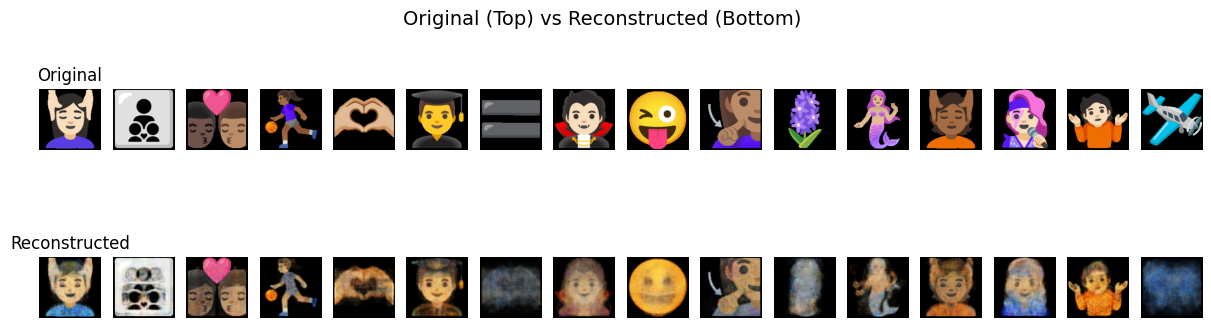

Epoch [10/300] | Train Loss: 17.3031 | Recon Loss: 517010.8091 | KL Loss: 3316.4802


Epoch 11/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.64it/s]


Epoch [11/300] | Train Loss: 19.3763 | Recon Loss: 507354.0334 | KL Loss: 3163.0254


Epoch 12/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.53it/s]


Epoch [12/300] | Train Loss: 18.3585 | Recon Loss: 501014.4248 | KL Loss: 3060.5642


Epoch 13/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.24it/s]


Epoch [13/300] | Train Loss: 16.2827 | Recon Loss: 496790.7820 | KL Loss: 3376.0769


Epoch 14/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.21it/s]


Epoch [14/300] | Train Loss: 14.9917 | Recon Loss: 490521.0384 | KL Loss: 3365.9148


Epoch 15/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.46it/s]


Epoch [15/300] | Train Loss: 22.1591 | Recon Loss: 486646.5606 | KL Loss: 3210.0933


Epoch 16/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.52it/s]


Epoch [16/300] | Train Loss: 18.3638 | Recon Loss: 481182.3731 | KL Loss: 3418.0896


Epoch 17/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.23it/s]


Epoch [17/300] | Train Loss: 18.5761 | Recon Loss: 478516.9778 | KL Loss: 3303.1282


Epoch 18/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.43it/s]


Epoch [18/300] | Train Loss: 14.5021 | Recon Loss: 473924.3382 | KL Loss: 3176.0073


Epoch 19/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.53it/s]


Epoch [19/300] | Train Loss: 16.2731 | Recon Loss: 469619.7082 | KL Loss: 2832.0488


Epoch 20/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.69it/s]


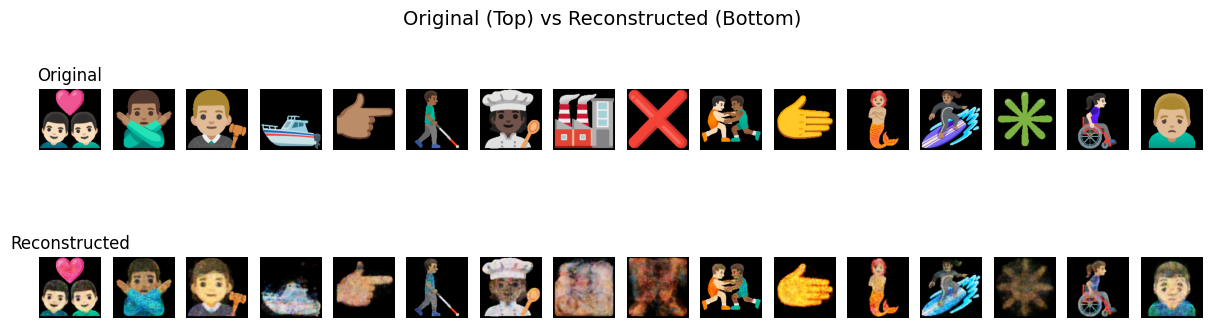

Epoch [20/300] | Train Loss: 16.6804 | Recon Loss: 467502.9380 | KL Loss: 3011.0356


Epoch 21/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.58it/s]


Epoch [21/300] | Train Loss: 19.4989 | Recon Loss: 464322.1997 | KL Loss: 2881.8413


Epoch 22/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.75it/s]


Epoch [22/300] | Train Loss: 20.5976 | Recon Loss: 461409.4449 | KL Loss: 2550.4556


Epoch 23/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.60it/s]


Epoch [23/300] | Train Loss: 15.8697 | Recon Loss: 458142.8477 | KL Loss: 3024.3882


Epoch 24/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.51it/s]


Epoch [24/300] | Train Loss: 16.5870 | Recon Loss: 455161.2839 | KL Loss: 2979.0464


Epoch 25/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.71it/s]


Epoch [25/300] | Train Loss: 20.0563 | Recon Loss: 452776.4690 | KL Loss: 2921.1150


Epoch 26/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.77it/s]


Epoch [26/300] | Train Loss: 17.2164 | Recon Loss: 449707.1639 | KL Loss: 2944.6074


Epoch 27/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.71it/s]


Epoch [27/300] | Train Loss: 19.7439 | Recon Loss: 447951.0254 | KL Loss: 2896.4661


Epoch 28/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.65it/s]


Epoch [28/300] | Train Loss: 20.1745 | Recon Loss: 445363.0294 | KL Loss: 2874.2166


Epoch 29/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.73it/s]


Epoch [29/300] | Train Loss: 18.1265 | Recon Loss: 444606.9883 | KL Loss: 2965.6375


Epoch 30/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.68it/s]


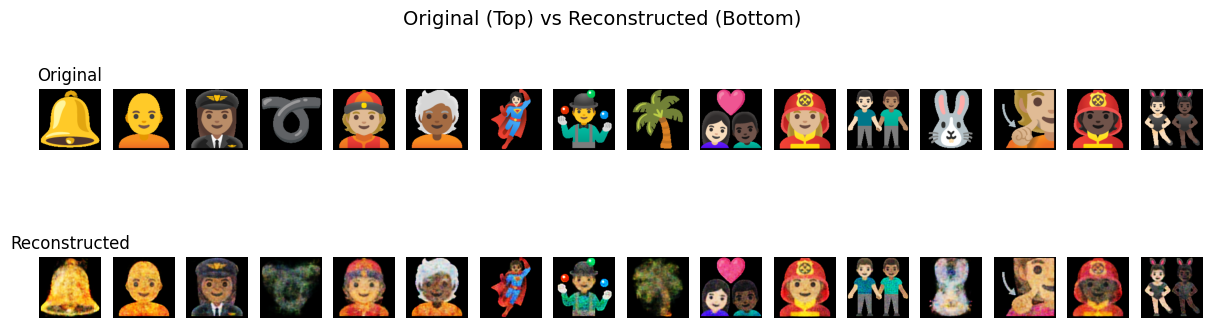

Epoch [30/300] | Train Loss: 18.1552 | Recon Loss: 442743.1658 | KL Loss: 2992.7939


Epoch 31/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.67it/s]


Epoch [31/300] | Train Loss: 15.4113 | Recon Loss: 439803.7368 | KL Loss: 2889.3418


Epoch 32/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.70it/s]


Epoch [32/300] | Train Loss: 17.7196 | Recon Loss: 438278.0869 | KL Loss: 2646.3137


Epoch 33/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.61it/s]


Epoch [33/300] | Train Loss: 15.9160 | Recon Loss: 437180.5834 | KL Loss: 2789.3647


Epoch 34/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.60it/s]


Epoch [34/300] | Train Loss: 17.4221 | Recon Loss: 435716.6864 | KL Loss: 2635.9736


Epoch 35/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.52it/s]


Epoch [35/300] | Train Loss: 22.2185 | Recon Loss: 433256.4947 | KL Loss: 2711.0388


Epoch 36/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.25it/s]


Epoch [36/300] | Train Loss: 14.8384 | Recon Loss: 432988.3141 | KL Loss: 2757.9973


Epoch 37/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.48it/s]


Epoch [37/300] | Train Loss: 16.0106 | Recon Loss: 431997.8424 | KL Loss: 2793.8740


Epoch 38/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.45it/s]


Epoch [38/300] | Train Loss: 13.7340 | Recon Loss: 430560.0466 | KL Loss: 3179.9673


Epoch 39/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.29it/s]


Epoch [39/300] | Train Loss: 15.6348 | Recon Loss: 428934.1351 | KL Loss: 3179.3184


Epoch 40/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.15it/s]


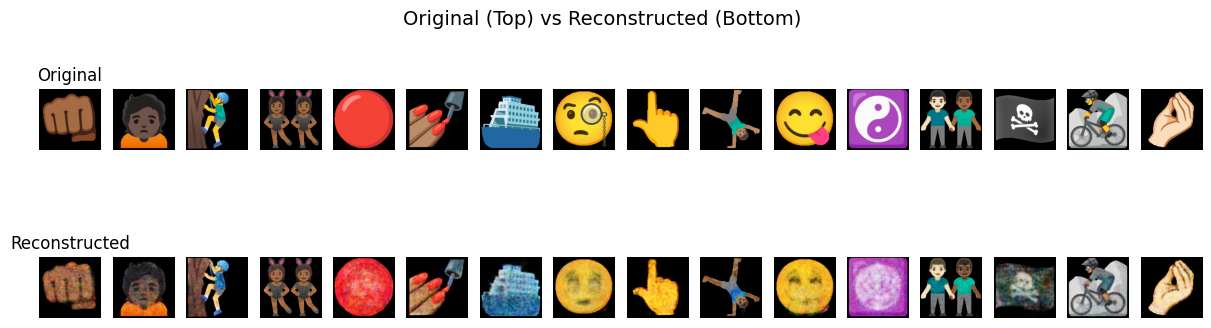

Epoch [40/300] | Train Loss: 15.3766 | Recon Loss: 427942.5326 | KL Loss: 2659.5237


Epoch 41/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.50it/s]


Epoch [41/300] | Train Loss: 19.8157 | Recon Loss: 427193.8329 | KL Loss: 3041.8569


Epoch 42/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.50it/s]


Epoch [42/300] | Train Loss: 14.8085 | Recon Loss: 426323.1811 | KL Loss: 2618.4778


Epoch 43/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.41it/s]


Epoch [43/300] | Train Loss: 15.0618 | Recon Loss: 425352.5644 | KL Loss: 2685.2495


Epoch 44/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.69it/s]


Epoch [44/300] | Train Loss: 14.0803 | Recon Loss: 424905.0233 | KL Loss: 2830.2825


Epoch 45/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.71it/s]


Epoch [45/300] | Train Loss: 12.7153 | Recon Loss: 423472.4494 | KL Loss: 2793.5833


Epoch 46/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.60it/s]


Epoch [46/300] | Train Loss: 15.0914 | Recon Loss: 422752.9243 | KL Loss: 2939.5344


Epoch 47/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.60it/s]


Epoch [47/300] | Train Loss: 15.1297 | Recon Loss: 423141.6226 | KL Loss: 2727.2817


Epoch 48/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.78it/s]


Epoch [48/300] | Train Loss: 15.4415 | Recon Loss: 422728.0233 | KL Loss: 2580.3357


Epoch 49/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.75it/s]


Epoch [49/300] | Train Loss: 14.5799 | Recon Loss: 421365.6396 | KL Loss: 2927.7959


Epoch 50/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.76it/s]


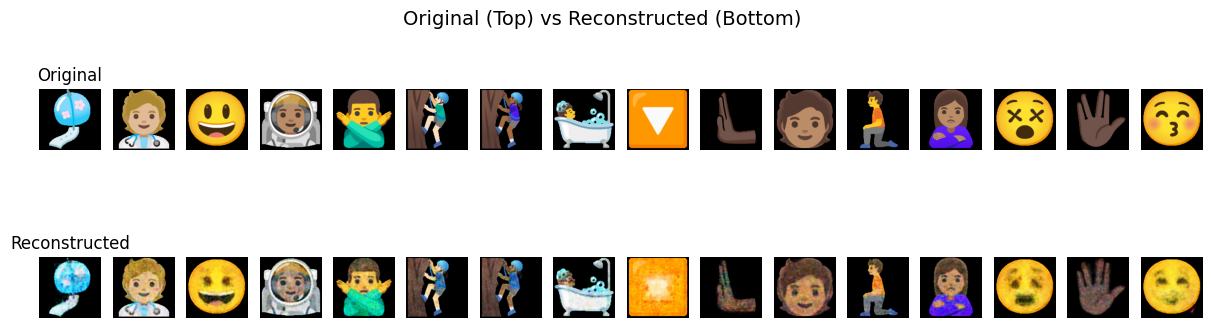

Epoch [50/300] | Train Loss: 15.3944 | Recon Loss: 420226.8612 | KL Loss: 2297.7532


Epoch 51/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.54it/s]


Epoch [51/300] | Train Loss: 14.1179 | Recon Loss: 420325.2468 | KL Loss: 2830.5801


Epoch 52/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.23it/s]


Epoch [52/300] | Train Loss: 15.4169 | Recon Loss: 419664.3260 | KL Loss: 2676.2949


Epoch 53/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.23it/s]


Epoch [53/300] | Train Loss: 13.6886 | Recon Loss: 419129.6216 | KL Loss: 2474.5967


Epoch 54/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.11it/s]


Epoch [54/300] | Train Loss: 10.4318 | Recon Loss: 418813.8204 | KL Loss: 2504.4395


Epoch 55/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.28it/s]


Epoch [55/300] | Train Loss: 11.1657 | Recon Loss: 417605.9727 | KL Loss: 2711.7178


Epoch 56/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.50it/s]


Epoch [56/300] | Train Loss: 15.1940 | Recon Loss: 416809.7005 | KL Loss: 2638.4458


Epoch 57/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.27it/s]


Epoch [57/300] | Train Loss: 13.4562 | Recon Loss: 417618.7511 | KL Loss: 2617.5151


Epoch 58/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.31it/s]


Epoch [58/300] | Train Loss: 13.7873 | Recon Loss: 416932.1030 | KL Loss: 2866.9019


Epoch 59/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.89it/s]


Epoch [59/300] | Train Loss: 14.7722 | Recon Loss: 416723.4733 | KL Loss: 2496.6965


Epoch 60/300 Training: 100%|██████████| 118/118 [00:08<00:00, 14.05it/s]


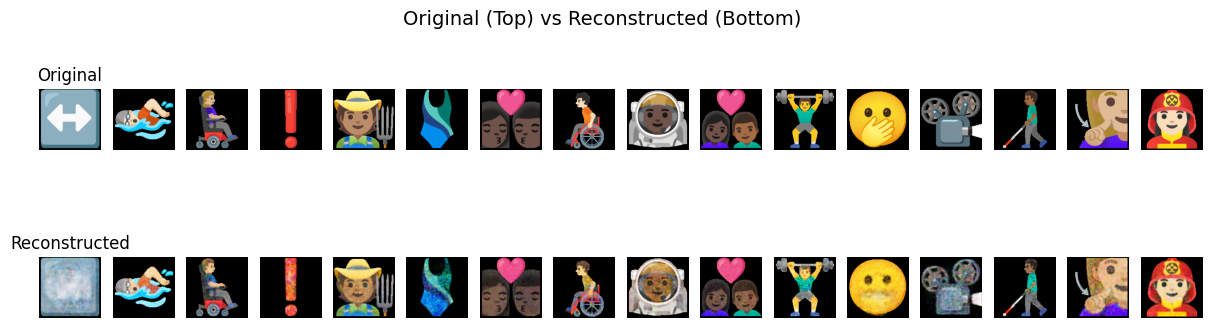

Epoch [60/300] | Train Loss: 14.3945 | Recon Loss: 415898.6430 | KL Loss: 2510.1116


Epoch 61/300 Training: 100%|██████████| 118/118 [00:08<00:00, 14.01it/s]


Epoch [61/300] | Train Loss: 11.3452 | Recon Loss: 415438.3223 | KL Loss: 2911.7092


Epoch 62/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.80it/s]


Epoch [62/300] | Train Loss: 13.3738 | Recon Loss: 415159.5029 | KL Loss: 2718.8210


Epoch 63/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.69it/s]


Epoch [63/300] | Train Loss: 12.4805 | Recon Loss: 414673.3912 | KL Loss: 2394.1250


Epoch 64/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.72it/s]


Epoch [64/300] | Train Loss: 10.2548 | Recon Loss: 414937.8273 | KL Loss: 2749.1794


Epoch 65/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.60it/s]


Epoch [65/300] | Train Loss: 12.7594 | Recon Loss: 414711.6380 | KL Loss: 2353.7908


Epoch 66/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.78it/s]


Epoch [66/300] | Train Loss: 14.0416 | Recon Loss: 413935.2987 | KL Loss: 2497.8523


Epoch 67/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.70it/s]


Epoch [67/300] | Train Loss: 11.2635 | Recon Loss: 413275.8742 | KL Loss: 2702.8491


Epoch 68/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.50it/s]


Epoch [68/300] | Train Loss: 11.2122 | Recon Loss: 413509.6483 | KL Loss: 2634.5063


Epoch 69/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.74it/s]


Epoch [69/300] | Train Loss: 13.7615 | Recon Loss: 413315.7553 | KL Loss: 2613.6763


Epoch 70/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.62it/s]


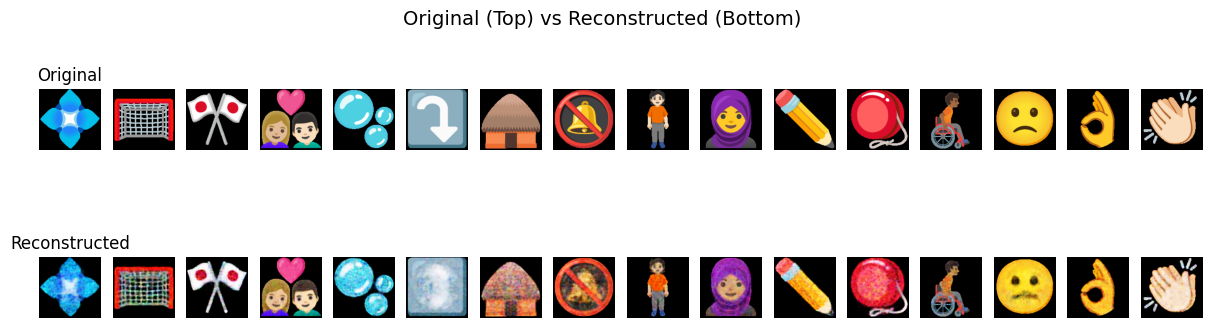

Epoch [70/300] | Train Loss: 14.4354 | Recon Loss: 412636.8120 | KL Loss: 2602.0571


Epoch 71/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.53it/s]


Epoch [71/300] | Train Loss: 11.3783 | Recon Loss: 412405.3350 | KL Loss: 2565.1863


Epoch 72/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.62it/s]


Epoch [72/300] | Train Loss: 11.1489 | Recon Loss: 412004.7119 | KL Loss: 2421.4402


Epoch 73/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.78it/s]


Epoch [73/300] | Train Loss: 12.5242 | Recon Loss: 411433.8901 | KL Loss: 2489.5513


Epoch 74/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.53it/s]


Epoch [74/300] | Train Loss: 12.3765 | Recon Loss: 411387.7937 | KL Loss: 2535.7129


Epoch 75/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.69it/s]


Epoch [75/300] | Train Loss: 10.2756 | Recon Loss: 411322.9139 | KL Loss: 2809.1101


Epoch 76/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.69it/s]


Epoch [76/300] | Train Loss: 11.8566 | Recon Loss: 410661.5413 | KL Loss: 2505.9941


Epoch 77/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.55it/s]


Epoch [77/300] | Train Loss: 11.2981 | Recon Loss: 410745.4007 | KL Loss: 2508.4548


Epoch 78/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.62it/s]


Epoch [78/300] | Train Loss: 11.1882 | Recon Loss: 410259.7410 | KL Loss: 2628.7935


Epoch 79/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.35it/s]


Epoch [79/300] | Train Loss: 10.4374 | Recon Loss: 409883.8451 | KL Loss: 2422.6643


Epoch 80/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.37it/s]


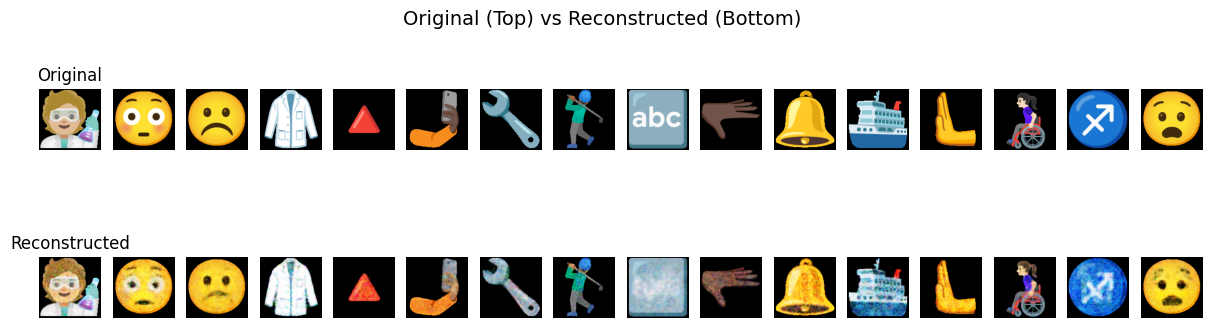

Epoch [80/300] | Train Loss: 10.1693 | Recon Loss: 410182.4531 | KL Loss: 2538.3496


Epoch 81/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.46it/s]


Epoch [81/300] | Train Loss: 10.5162 | Recon Loss: 409895.5593 | KL Loss: 2812.1687


Epoch 82/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.54it/s]


Epoch [82/300] | Train Loss: 11.6554 | Recon Loss: 409203.5183 | KL Loss: 2663.4294


Epoch 83/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.72it/s]


Epoch [83/300] | Train Loss: 9.5980 | Recon Loss: 409048.7015 | KL Loss: 3014.7666


Epoch 84/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.54it/s]


Epoch [84/300] | Train Loss: 13.0587 | Recon Loss: 408788.7037 | KL Loss: 2672.2583


Epoch 85/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.81it/s]


Epoch [85/300] | Train Loss: 10.6676 | Recon Loss: 408347.1480 | KL Loss: 2744.1165


Epoch 86/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.69it/s]


Epoch [86/300] | Train Loss: 8.8171 | Recon Loss: 408314.6700 | KL Loss: 2610.3528


Epoch 87/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.60it/s]


Epoch [87/300] | Train Loss: 8.9292 | Recon Loss: 407992.3898 | KL Loss: 2736.0464


Epoch 88/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.55it/s]


Epoch [88/300] | Train Loss: 10.5909 | Recon Loss: 408040.5805 | KL Loss: 2711.4368


Epoch 89/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.61it/s]


Epoch [89/300] | Train Loss: 10.4973 | Recon Loss: 408320.5262 | KL Loss: 2649.3462


Epoch 90/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.44it/s]


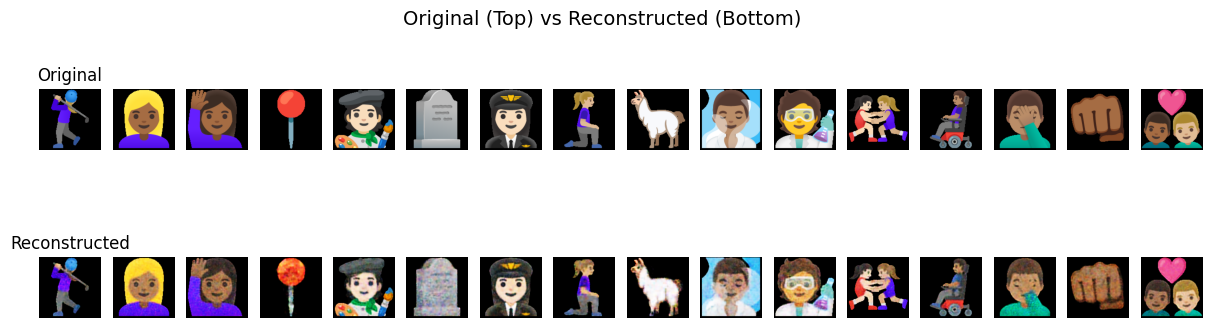

Epoch [90/300] | Train Loss: 10.6173 | Recon Loss: 407947.5877 | KL Loss: 2630.5757


Epoch 91/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.73it/s]


Epoch [91/300] | Train Loss: 10.7538 | Recon Loss: 407606.6455 | KL Loss: 2215.7791


Epoch 92/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.57it/s]


Epoch [92/300] | Train Loss: 10.4858 | Recon Loss: 407767.9317 | KL Loss: 2733.1267


Epoch 93/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.59it/s]


Epoch [93/300] | Train Loss: 11.0869 | Recon Loss: 406962.1700 | KL Loss: 2259.5432


Epoch 94/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.72it/s]


Epoch [94/300] | Train Loss: 10.7446 | Recon Loss: 407026.0580 | KL Loss: 2566.1726


Epoch 95/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.70it/s]


Epoch [95/300] | Train Loss: 9.8031 | Recon Loss: 407356.4838 | KL Loss: 2562.7632


Epoch 96/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.65it/s]


Epoch [96/300] | Train Loss: 9.6978 | Recon Loss: 407872.9227 | KL Loss: 2568.5217


Epoch 97/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.46it/s]


Epoch [97/300] | Train Loss: 11.4057 | Recon Loss: 406456.2434 | KL Loss: 2618.7551


Epoch 98/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.74it/s]


Epoch [98/300] | Train Loss: 9.0675 | Recon Loss: 407055.6811 | KL Loss: 2907.1091


Epoch 99/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.61it/s]


Epoch [99/300] | Train Loss: 10.0043 | Recon Loss: 406226.3159 | KL Loss: 2859.2275


Epoch 100/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.79it/s]


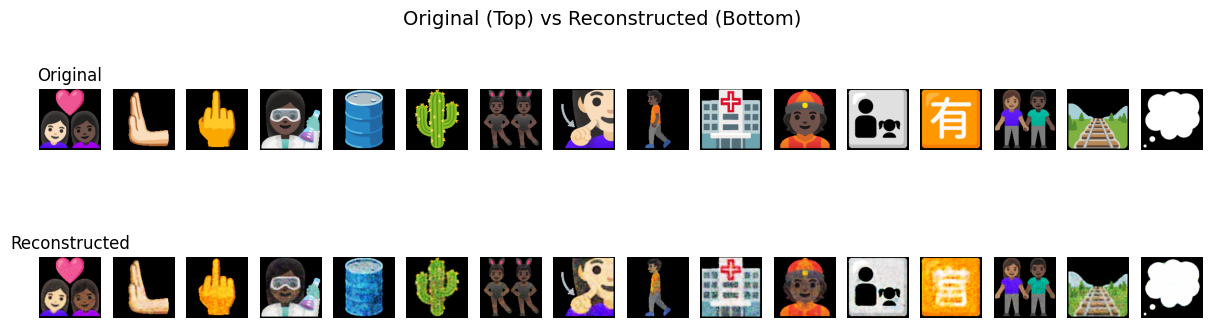

Epoch [100/300] | Train Loss: 10.1451 | Recon Loss: 406390.6878 | KL Loss: 2665.0120


Epoch 101/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.63it/s]


Epoch [101/300] | Train Loss: 10.0267 | Recon Loss: 406102.9462 | KL Loss: 2700.7119


Epoch 102/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.64it/s]


Epoch [102/300] | Train Loss: 7.9000 | Recon Loss: 406277.5895 | KL Loss: 2474.2522


Epoch 103/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.61it/s]


Epoch [103/300] | Train Loss: 8.7824 | Recon Loss: 406188.9672 | KL Loss: 2508.5691


Epoch 104/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.65it/s]


Epoch [104/300] | Train Loss: 10.5194 | Recon Loss: 405157.0196 | KL Loss: 2912.1614


Epoch 105/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.75it/s]


Epoch [105/300] | Train Loss: 10.7515 | Recon Loss: 405591.5826 | KL Loss: 2402.3054


Epoch 106/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.69it/s]


Epoch [106/300] | Train Loss: 9.4799 | Recon Loss: 405667.9944 | KL Loss: 2635.1399


Epoch 107/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.50it/s]


Epoch [107/300] | Train Loss: 9.7316 | Recon Loss: 405004.2680 | KL Loss: 2500.5293


Epoch 108/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.63it/s]


Epoch [108/300] | Train Loss: 9.0029 | Recon Loss: 405302.2217 | KL Loss: 2793.6448


Epoch 109/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.74it/s]


Epoch [109/300] | Train Loss: 9.9985 | Recon Loss: 405423.5400 | KL Loss: 2455.5190


Epoch 110/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.66it/s]


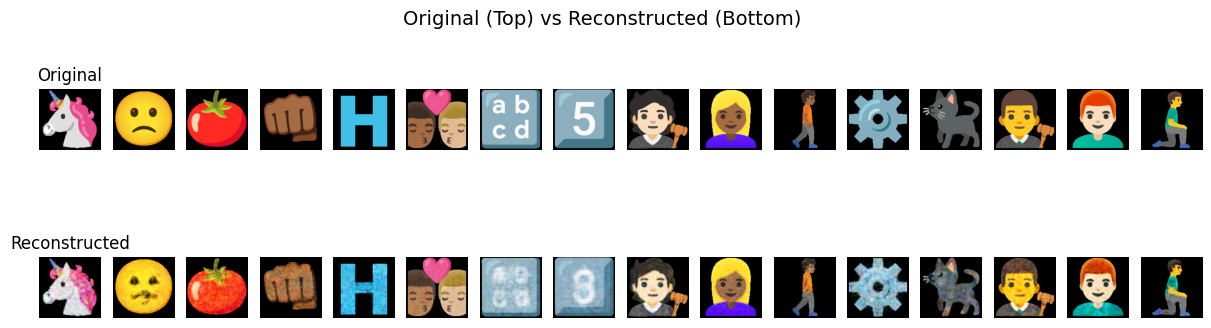

Epoch [110/300] | Train Loss: 10.4795 | Recon Loss: 405232.7929 | KL Loss: 2258.4778


Epoch 111/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.69it/s]


Epoch [111/300] | Train Loss: 9.6091 | Recon Loss: 405255.5535 | KL Loss: 2646.4985


Epoch 112/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.71it/s]


Epoch [112/300] | Train Loss: 7.3625 | Recon Loss: 404384.8829 | KL Loss: 2696.8696


Epoch 113/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.72it/s]


Epoch [113/300] | Train Loss: 9.1194 | Recon Loss: 404806.2760 | KL Loss: 2633.1748


Epoch 114/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.73it/s]


Epoch [114/300] | Train Loss: 8.4886 | Recon Loss: 404412.2516 | KL Loss: 2497.1479


Epoch 115/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.48it/s]


Epoch [115/300] | Train Loss: 9.7477 | Recon Loss: 404500.4309 | KL Loss: 2523.4263


Epoch 116/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.74it/s]


Epoch [116/300] | Train Loss: 9.6189 | Recon Loss: 404462.1427 | KL Loss: 2374.8308


Epoch 117/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.64it/s]


Epoch [117/300] | Train Loss: 10.1377 | Recon Loss: 404050.6539 | KL Loss: 2817.0332


Epoch 118/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.51it/s]


Epoch [118/300] | Train Loss: 9.2209 | Recon Loss: 404113.0731 | KL Loss: 2425.2727


Epoch 119/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.64it/s]


Epoch [119/300] | Train Loss: 7.6221 | Recon Loss: 404603.9762 | KL Loss: 2607.7729


Epoch 120/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.51it/s]


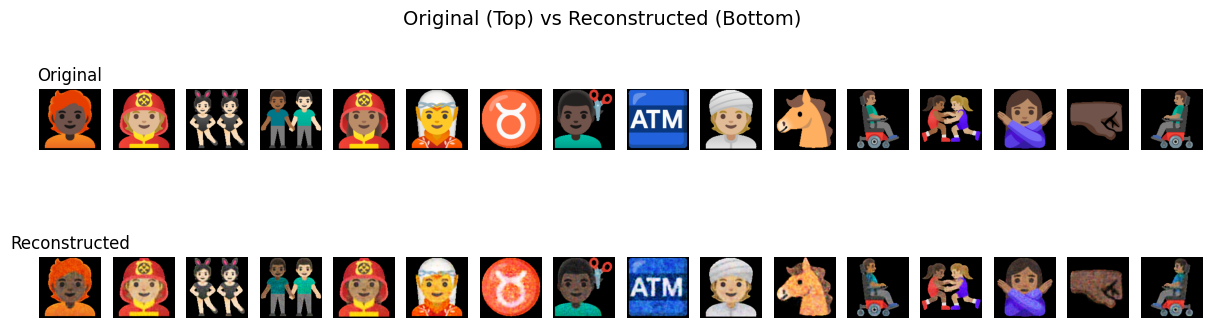

Epoch [120/300] | Train Loss: 7.5380 | Recon Loss: 403555.8803 | KL Loss: 2905.5498


Epoch 121/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.74it/s]


Epoch [121/300] | Train Loss: 9.4015 | Recon Loss: 403540.4486 | KL Loss: 2704.8701


Epoch 122/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.62it/s]


Epoch [122/300] | Train Loss: 8.1216 | Recon Loss: 403981.9672 | KL Loss: 2460.0186


Epoch 123/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.72it/s]


Epoch [123/300] | Train Loss: 8.9112 | Recon Loss: 403288.2190 | KL Loss: 2511.0325


Epoch 124/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.71it/s]


Epoch [124/300] | Train Loss: 8.9712 | Recon Loss: 403176.8774 | KL Loss: 1966.5651


Epoch 125/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.47it/s]


Epoch [125/300] | Train Loss: 8.6957 | Recon Loss: 403228.9296 | KL Loss: 2405.0525


Epoch 126/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.54it/s]


Epoch [126/300] | Train Loss: 9.0009 | Recon Loss: 403266.7558 | KL Loss: 2557.0752


Epoch 127/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.74it/s]


Epoch [127/300] | Train Loss: 7.6832 | Recon Loss: 402993.4632 | KL Loss: 2527.9321


Epoch 128/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.64it/s]


Epoch [128/300] | Train Loss: 8.0294 | Recon Loss: 403153.9417 | KL Loss: 2406.7019


Epoch 129/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.77it/s]


Epoch [129/300] | Train Loss: 7.7524 | Recon Loss: 402806.0739 | KL Loss: 2659.2029


Epoch 130/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.71it/s]


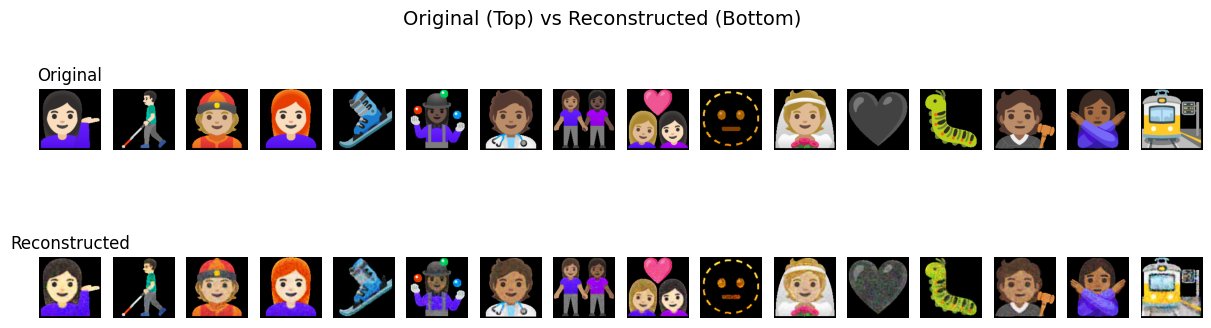

Epoch [130/300] | Train Loss: 7.9579 | Recon Loss: 402518.2595 | KL Loss: 2745.0208


Epoch 131/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.60it/s]


Epoch [131/300] | Train Loss: 8.0932 | Recon Loss: 402307.8112 | KL Loss: 2524.0076


Epoch 132/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.57it/s]


Epoch [132/300] | Train Loss: 8.7384 | Recon Loss: 402664.8069 | KL Loss: 2376.7852


Epoch 133/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.67it/s]


Epoch [133/300] | Train Loss: 7.4985 | Recon Loss: 402466.1541 | KL Loss: 2716.5376


Epoch 134/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.78it/s]


Epoch [134/300] | Train Loss: 8.3178 | Recon Loss: 402482.0514 | KL Loss: 2632.6914


Epoch 135/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.77it/s]


Epoch [135/300] | Train Loss: 8.5414 | Recon Loss: 402927.3512 | KL Loss: 2786.3130


Epoch 136/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.65it/s]


Epoch [136/300] | Train Loss: 6.9805 | Recon Loss: 402733.2055 | KL Loss: 2729.2480


Epoch 137/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.72it/s]


Epoch [137/300] | Train Loss: 8.4498 | Recon Loss: 402875.7354 | KL Loss: 2618.2490


Epoch 138/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.59it/s]


Epoch [138/300] | Train Loss: 8.3163 | Recon Loss: 402306.1231 | KL Loss: 2470.3689


Epoch 139/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.70it/s]


Epoch [139/300] | Train Loss: 7.9660 | Recon Loss: 401956.5853 | KL Loss: 2532.5959


Epoch 140/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.57it/s]


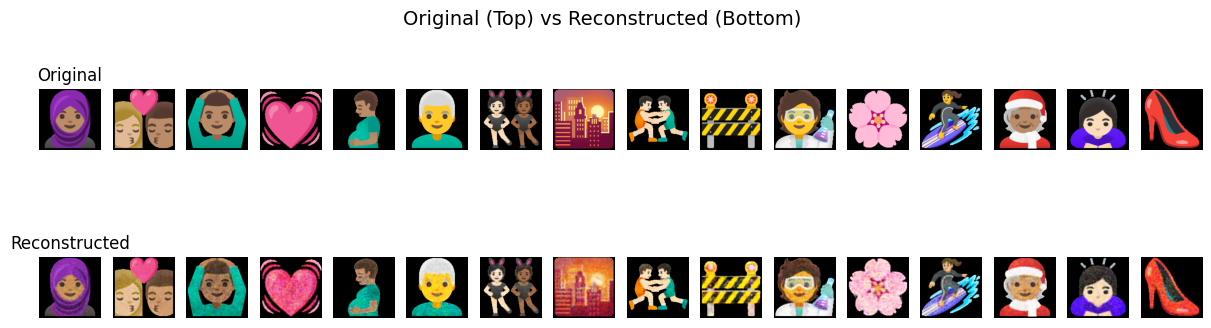

Epoch [140/300] | Train Loss: 7.5917 | Recon Loss: 401558.3014 | KL Loss: 2590.2908


Epoch 141/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.35it/s]


Epoch [141/300] | Train Loss: 7.5283 | Recon Loss: 401961.1864 | KL Loss: 2488.9414


Epoch 142/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.60it/s]


Epoch [142/300] | Train Loss: 8.4323 | Recon Loss: 402005.8922 | KL Loss: 2324.8967


Epoch 143/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.76it/s]


Epoch [143/300] | Train Loss: 7.4730 | Recon Loss: 401892.8006 | KL Loss: 3037.3804


Epoch 144/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.72it/s]


Epoch [144/300] | Train Loss: 8.9246 | Recon Loss: 402089.9041 | KL Loss: 2676.8564


Epoch 145/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.52it/s]


Epoch [145/300] | Train Loss: 8.0357 | Recon Loss: 402203.9253 | KL Loss: 2651.6345


Epoch 146/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.54it/s]


Epoch [146/300] | Train Loss: 7.7989 | Recon Loss: 402148.8796 | KL Loss: 2166.4434


Epoch 147/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.52it/s]


Epoch [147/300] | Train Loss: 7.0769 | Recon Loss: 402082.4311 | KL Loss: 2424.6050


Epoch 148/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.60it/s]


Epoch [148/300] | Train Loss: 7.7896 | Recon Loss: 401703.8694 | KL Loss: 2819.2878


Epoch 149/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.65it/s]


Epoch [149/300] | Train Loss: 7.3807 | Recon Loss: 401871.0972 | KL Loss: 2192.0986


Epoch 150/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.64it/s]


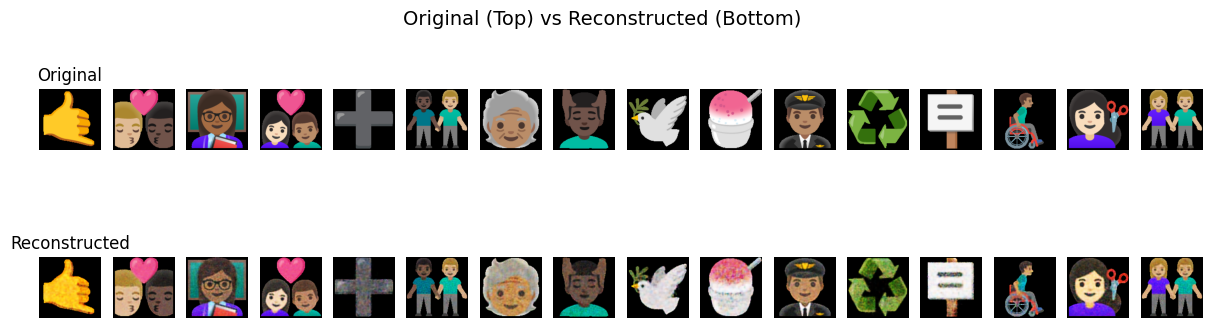

Epoch [150/300] | Train Loss: 8.0022 | Recon Loss: 401208.8117 | KL Loss: 2422.0647


Epoch 151/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.53it/s]


Epoch [151/300] | Train Loss: 7.6848 | Recon Loss: 400935.9995 | KL Loss: 2655.5527


Epoch 152/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.60it/s]


Epoch [152/300] | Train Loss: 7.6555 | Recon Loss: 401553.0524 | KL Loss: 2569.2676


Epoch 153/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.74it/s]


Epoch [153/300] | Train Loss: 7.6903 | Recon Loss: 401922.1286 | KL Loss: 2206.2644


Epoch 154/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.53it/s]


Epoch [154/300] | Train Loss: 7.2683 | Recon Loss: 401544.1806 | KL Loss: 2699.5615


Epoch 155/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.48it/s]


Epoch [155/300] | Train Loss: 8.7710 | Recon Loss: 400770.2246 | KL Loss: 2220.0764


Epoch 156/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.75it/s]


Epoch [156/300] | Train Loss: 7.7022 | Recon Loss: 400738.6947 | KL Loss: 2376.8020


Epoch 157/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.75it/s]


Epoch [157/300] | Train Loss: 7.2195 | Recon Loss: 401431.7858 | KL Loss: 2853.5793


Epoch 158/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.64it/s]


Epoch [158/300] | Train Loss: 6.7826 | Recon Loss: 401194.8739 | KL Loss: 2681.0264


Epoch 159/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.48it/s]


Epoch [159/300] | Train Loss: 8.5510 | Recon Loss: 401152.4992 | KL Loss: 2444.8159


Epoch 160/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.63it/s]


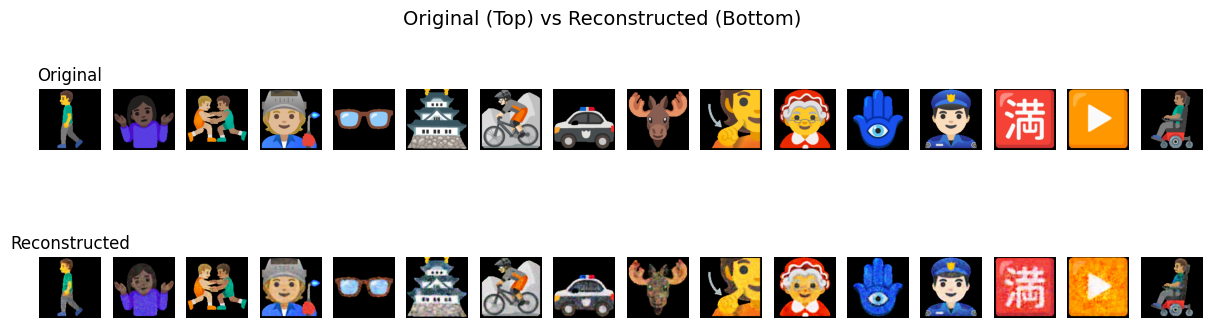

Epoch [160/300] | Train Loss: 7.6832 | Recon Loss: 401017.2431 | KL Loss: 2564.8560


Epoch 161/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.78it/s]


Epoch [161/300] | Train Loss: 7.7217 | Recon Loss: 401059.6263 | KL Loss: 2198.4810


Epoch 162/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.75it/s]


Epoch [162/300] | Train Loss: 7.2690 | Recon Loss: 400611.2534 | KL Loss: 2878.0564


Epoch 163/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.71it/s]


Epoch [163/300] | Train Loss: 8.2434 | Recon Loss: 400689.5919 | KL Loss: 2714.6658


Epoch 164/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.50it/s]


Epoch [164/300] | Train Loss: 6.9286 | Recon Loss: 400600.2770 | KL Loss: 2609.3286


Epoch 165/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.60it/s]


Epoch [165/300] | Train Loss: 7.2807 | Recon Loss: 401342.7479 | KL Loss: 2350.4280


Epoch 166/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.48it/s]


Epoch [166/300] | Train Loss: 6.9700 | Recon Loss: 400598.6777 | KL Loss: 2695.1648


Epoch 167/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.46it/s]


Epoch [167/300] | Train Loss: 7.0013 | Recon Loss: 400297.2950 | KL Loss: 2544.9424


Epoch 168/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.37it/s]


Epoch [168/300] | Train Loss: 7.4298 | Recon Loss: 400537.8557 | KL Loss: 2490.0259


Epoch 169/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.46it/s]


Epoch [169/300] | Train Loss: 6.7207 | Recon Loss: 400317.1279 | KL Loss: 2622.8955


Epoch 170/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.51it/s]


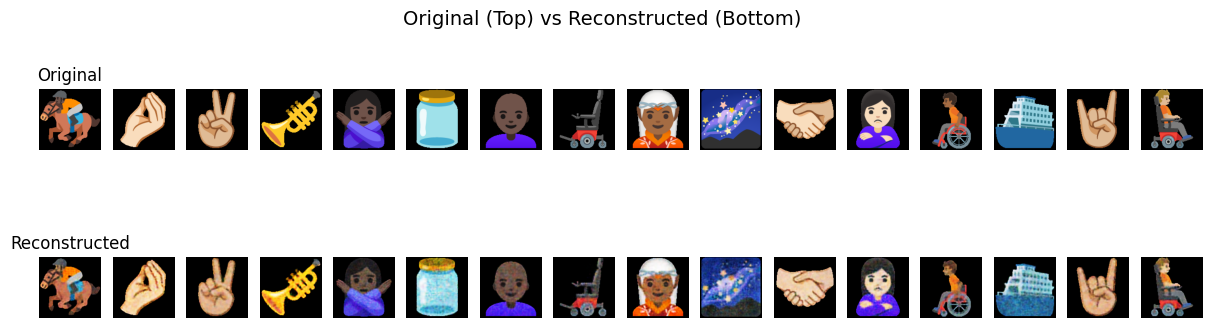

Epoch [170/300] | Train Loss: 7.6288 | Recon Loss: 400383.1096 | KL Loss: 2594.5903


Epoch 171/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.32it/s]


Epoch [171/300] | Train Loss: 6.3196 | Recon Loss: 400284.4004 | KL Loss: 2814.9402


Epoch 172/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.41it/s]


Epoch [172/300] | Train Loss: 7.1487 | Recon Loss: 399986.5440 | KL Loss: 2639.1621


Epoch 173/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.37it/s]


Epoch [173/300] | Train Loss: 7.0446 | Recon Loss: 400196.4489 | KL Loss: 2589.3284


Epoch 174/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.52it/s]


Epoch [174/300] | Train Loss: 7.1123 | Recon Loss: 400414.5818 | KL Loss: 2854.1748


Epoch 175/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.47it/s]


Epoch [175/300] | Train Loss: 7.1552 | Recon Loss: 400196.2503 | KL Loss: 2035.4578


Epoch 176/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.62it/s]


Epoch [176/300] | Train Loss: 6.6830 | Recon Loss: 399911.8861 | KL Loss: 2468.8979


Epoch 177/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.71it/s]


Epoch [177/300] | Train Loss: 6.4808 | Recon Loss: 400203.4280 | KL Loss: 2577.2166


Epoch 178/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.79it/s]


Epoch [178/300] | Train Loss: 7.2696 | Recon Loss: 400168.5469 | KL Loss: 2418.2136


Epoch 179/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.61it/s]


Epoch [179/300] | Train Loss: 6.6871 | Recon Loss: 400039.2238 | KL Loss: 2704.1064


Epoch 180/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.48it/s]


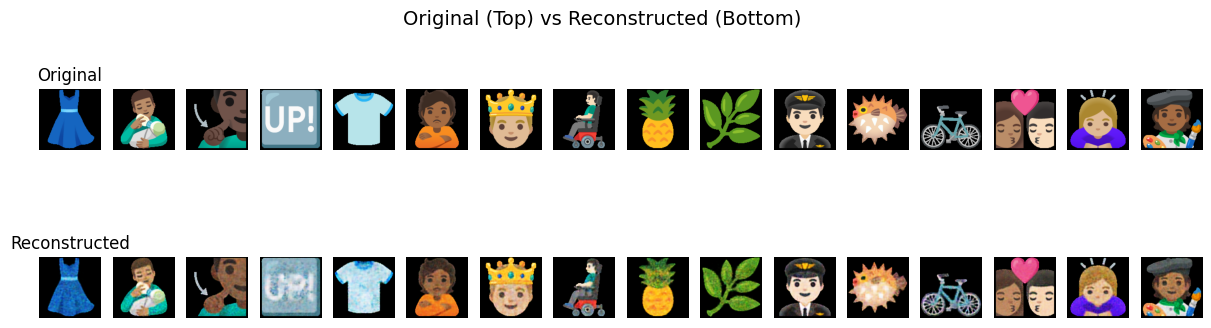

Epoch [180/300] | Train Loss: 6.8518 | Recon Loss: 400217.8567 | KL Loss: 2739.2644


Epoch 181/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.73it/s]


Epoch [181/300] | Train Loss: 7.4944 | Recon Loss: 399735.2050 | KL Loss: 2925.4856


Epoch 182/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.83it/s]


Epoch [182/300] | Train Loss: 7.2143 | Recon Loss: 399492.2037 | KL Loss: 2672.4053


Epoch 183/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.53it/s]


Epoch [183/300] | Train Loss: 7.1140 | Recon Loss: 399539.5471 | KL Loss: 2605.9814


Epoch 184/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.59it/s]


Epoch [184/300] | Train Loss: 7.1331 | Recon Loss: 399704.0673 | KL Loss: 3001.3755


Epoch 185/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.70it/s]


Epoch [185/300] | Train Loss: 7.3208 | Recon Loss: 399503.7701 | KL Loss: 2156.7075


Epoch 186/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.64it/s]


Epoch [186/300] | Train Loss: 7.1089 | Recon Loss: 399703.5996 | KL Loss: 2632.3645


Epoch 187/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.86it/s]


Epoch [187/300] | Train Loss: 7.5111 | Recon Loss: 399601.6488 | KL Loss: 2531.3401


Epoch 188/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.68it/s]


Epoch [188/300] | Train Loss: 7.2327 | Recon Loss: 399968.9555 | KL Loss: 2431.8906


Epoch 189/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.67it/s]


Epoch [189/300] | Train Loss: 6.7232 | Recon Loss: 399590.1623 | KL Loss: 2881.9800


Epoch 190/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.68it/s]


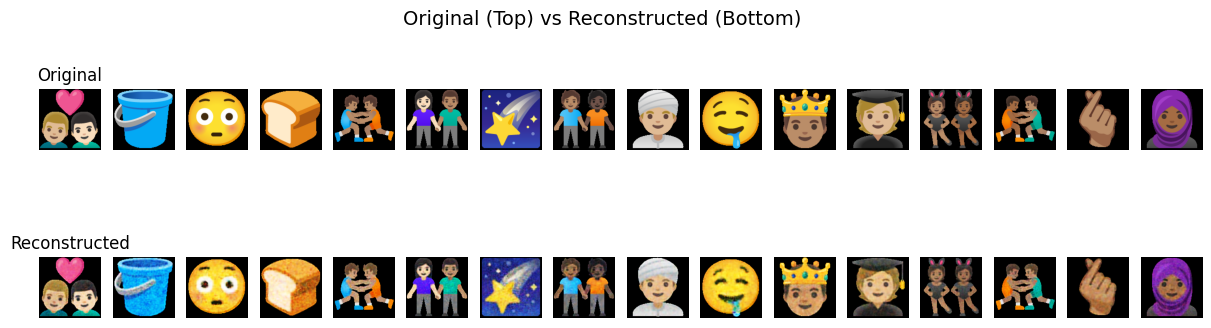

Epoch [190/300] | Train Loss: 6.5262 | Recon Loss: 399552.4958 | KL Loss: 2495.8938


Epoch 191/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.53it/s]


Epoch [191/300] | Train Loss: 6.6761 | Recon Loss: 399212.7132 | KL Loss: 2648.9956


Epoch 192/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.68it/s]


Epoch [192/300] | Train Loss: 7.3312 | Recon Loss: 399045.8870 | KL Loss: 2214.7983


Epoch 193/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.62it/s]


Epoch [193/300] | Train Loss: 6.0457 | Recon Loss: 399204.7564 | KL Loss: 2578.7932


Epoch 194/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.70it/s]


Epoch [194/300] | Train Loss: 6.1126 | Recon Loss: 399637.3046 | KL Loss: 2481.8572


Epoch 195/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.59it/s]


Epoch [195/300] | Train Loss: 6.9959 | Recon Loss: 399630.0768 | KL Loss: 2403.0381


Epoch 196/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.48it/s]


Epoch [196/300] | Train Loss: 6.8782 | Recon Loss: 399388.7254 | KL Loss: 2465.2832


Epoch 197/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.92it/s]


Epoch [197/300] | Train Loss: 6.3248 | Recon Loss: 399028.0617 | KL Loss: 2533.8552


Epoch 198/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.36it/s]


Epoch [198/300] | Train Loss: 6.5445 | Recon Loss: 399134.5551 | KL Loss: 2336.3098


Epoch 199/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.67it/s]


Epoch [199/300] | Train Loss: 6.4370 | Recon Loss: 399157.5111 | KL Loss: 2780.0349


Epoch 200/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.67it/s]


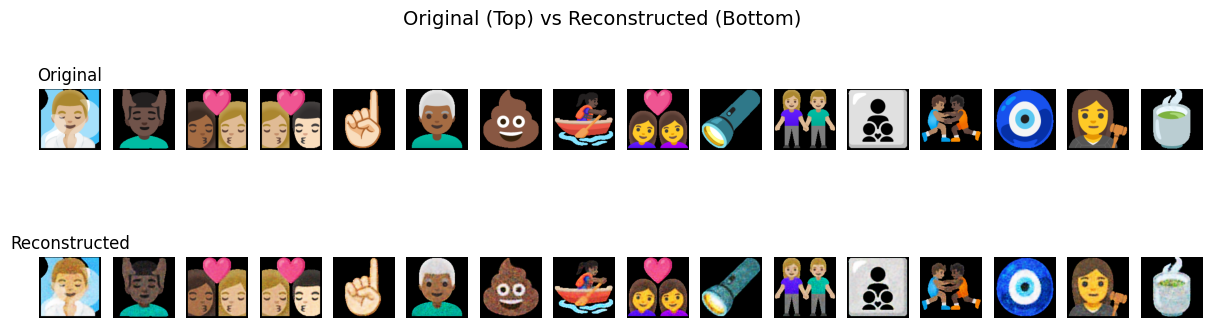

Epoch [200/300] | Train Loss: 6.4190 | Recon Loss: 398855.1600 | KL Loss: 2674.1143


Epoch 201/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.74it/s]


Epoch [201/300] | Train Loss: 6.4618 | Recon Loss: 399120.7270 | KL Loss: 2598.4360


Epoch 202/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.88it/s]


Epoch [202/300] | Train Loss: 6.7002 | Recon Loss: 399370.2047 | KL Loss: 2408.5886


Epoch 203/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.62it/s]


Epoch [203/300] | Train Loss: 6.8089 | Recon Loss: 398806.9897 | KL Loss: 2178.5857


Epoch 204/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.64it/s]


Epoch [204/300] | Train Loss: 6.6760 | Recon Loss: 398878.0789 | KL Loss: 3179.3274


Epoch 205/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.85it/s]


Epoch [205/300] | Train Loss: 6.7125 | Recon Loss: 399006.9971 | KL Loss: 2668.9683


Epoch 206/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.81it/s]


Epoch [206/300] | Train Loss: 6.2445 | Recon Loss: 399001.9597 | KL Loss: 2534.8071


Epoch 207/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.68it/s]


Epoch [207/300] | Train Loss: 6.2903 | Recon Loss: 398828.4399 | KL Loss: 2411.9392


Epoch 208/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.62it/s]


Epoch [208/300] | Train Loss: 7.4410 | Recon Loss: 398340.2675 | KL Loss: 2438.7991


Epoch 209/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.75it/s]


Epoch [209/300] | Train Loss: 6.8485 | Recon Loss: 398805.6735 | KL Loss: 2612.8918


Epoch 210/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.61it/s]


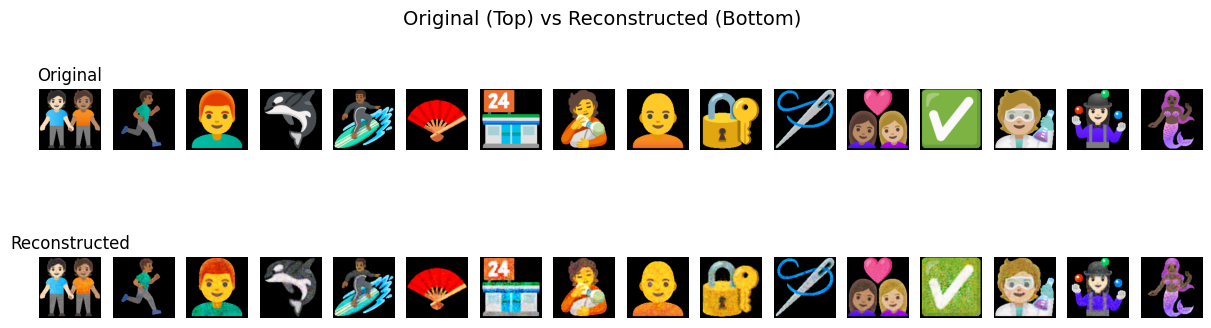

Epoch [210/300] | Train Loss: 6.9606 | Recon Loss: 399222.7974 | KL Loss: 2541.0481


Epoch 211/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.83it/s]


Epoch [211/300] | Train Loss: 6.7106 | Recon Loss: 399176.2746 | KL Loss: 2229.1050


Epoch 212/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.70it/s]


Epoch [212/300] | Train Loss: 6.3149 | Recon Loss: 399116.1165 | KL Loss: 2243.6841


Epoch 213/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.71it/s]


Epoch [213/300] | Train Loss: 6.6426 | Recon Loss: 398569.1584 | KL Loss: 2225.0054


Epoch 214/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.70it/s]


Epoch [214/300] | Train Loss: 6.1278 | Recon Loss: 399058.4942 | KL Loss: 2673.6025


Epoch 215/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.66it/s]


Epoch [215/300] | Train Loss: 6.3748 | Recon Loss: 398506.2823 | KL Loss: 2426.0510


Epoch 216/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.64it/s]


Epoch [216/300] | Train Loss: 5.7601 | Recon Loss: 398737.6957 | KL Loss: 2586.7654


Epoch 217/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.60it/s]


Epoch [217/300] | Train Loss: 6.2388 | Recon Loss: 398867.5408 | KL Loss: 2499.4053


Epoch 218/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.70it/s]


Epoch [218/300] | Train Loss: 6.3180 | Recon Loss: 398831.0919 | KL Loss: 2977.5964


Epoch 219/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.76it/s]


Epoch [219/300] | Train Loss: 6.8387 | Recon Loss: 399228.8761 | KL Loss: 2274.0195


Epoch 220/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.79it/s]


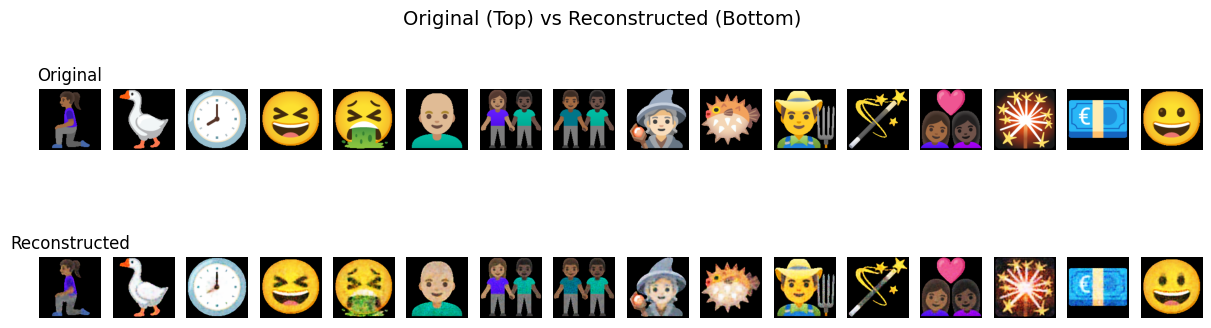

Epoch [220/300] | Train Loss: 6.2209 | Recon Loss: 399173.1809 | KL Loss: 2646.3706


Epoch 221/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.56it/s]


Epoch [221/300] | Train Loss: 6.2054 | Recon Loss: 398752.2248 | KL Loss: 2469.1372


Epoch 222/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.74it/s]


Epoch [222/300] | Train Loss: 6.0385 | Recon Loss: 398296.7481 | KL Loss: 2596.1260


Epoch 223/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.70it/s]


Epoch [223/300] | Train Loss: 6.2471 | Recon Loss: 398574.7188 | KL Loss: 2646.2837


Epoch 224/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.74it/s]


Epoch [224/300] | Train Loss: 6.5035 | Recon Loss: 398054.8130 | KL Loss: 2456.8904


Epoch 225/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.55it/s]


Epoch [225/300] | Train Loss: 6.6027 | Recon Loss: 397857.8604 | KL Loss: 2706.7517


Epoch 226/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.78it/s]


Epoch [226/300] | Train Loss: 6.4438 | Recon Loss: 398198.7405 | KL Loss: 2732.2039


Epoch 227/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.77it/s]


Epoch [227/300] | Train Loss: 6.6959 | Recon Loss: 398284.4934 | KL Loss: 2629.2126


Epoch 228/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.46it/s]


Epoch [228/300] | Train Loss: 6.6302 | Recon Loss: 398052.9010 | KL Loss: 2681.6987


Epoch 229/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.67it/s]


Epoch [229/300] | Train Loss: 6.0000 | Recon Loss: 398182.8064 | KL Loss: 2328.5522


Epoch 230/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.68it/s]


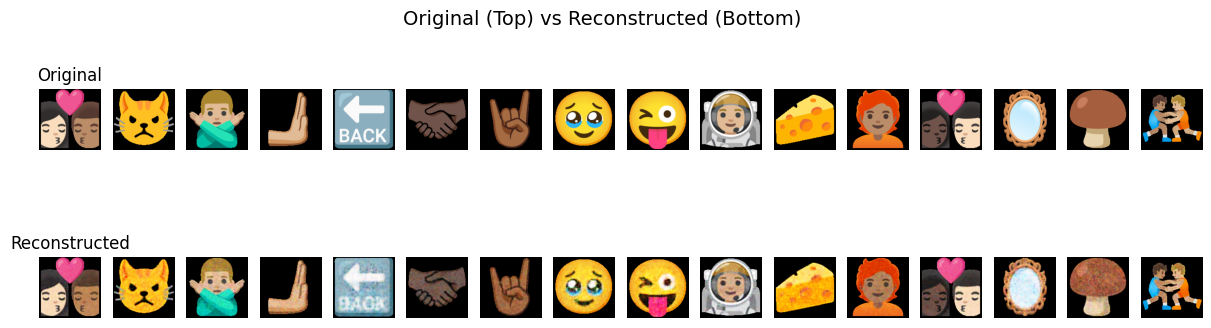

Epoch [230/300] | Train Loss: 5.8758 | Recon Loss: 397706.1398 | KL Loss: 2707.2356


Epoch 231/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.58it/s]


Epoch [231/300] | Train Loss: 6.0548 | Recon Loss: 397978.8183 | KL Loss: 2452.4736


Epoch 232/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.84it/s]


Epoch [232/300] | Train Loss: 6.2980 | Recon Loss: 398276.8684 | KL Loss: 2710.8767


Epoch 233/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.72it/s]


Epoch [233/300] | Train Loss: 6.2926 | Recon Loss: 398463.0993 | KL Loss: 2633.7959


Epoch 234/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.70it/s]


Epoch [234/300] | Train Loss: 6.5851 | Recon Loss: 398075.4232 | KL Loss: 2824.3145


Epoch 235/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.84it/s]


Epoch [235/300] | Train Loss: 5.6348 | Recon Loss: 398101.2278 | KL Loss: 2469.7910


Epoch 236/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.65it/s]


Epoch [236/300] | Train Loss: 5.6777 | Recon Loss: 398278.8520 | KL Loss: 2980.3960


Epoch 237/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.73it/s]


Epoch [237/300] | Train Loss: 6.2068 | Recon Loss: 398456.4796 | KL Loss: 2579.0667


Epoch 238/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.70it/s]


Epoch [238/300] | Train Loss: 6.3920 | Recon Loss: 398598.7304 | KL Loss: 2466.7368


Epoch 239/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.49it/s]


Epoch [239/300] | Train Loss: 6.4744 | Recon Loss: 398567.7540 | KL Loss: 2432.4854


Epoch 240/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.62it/s]


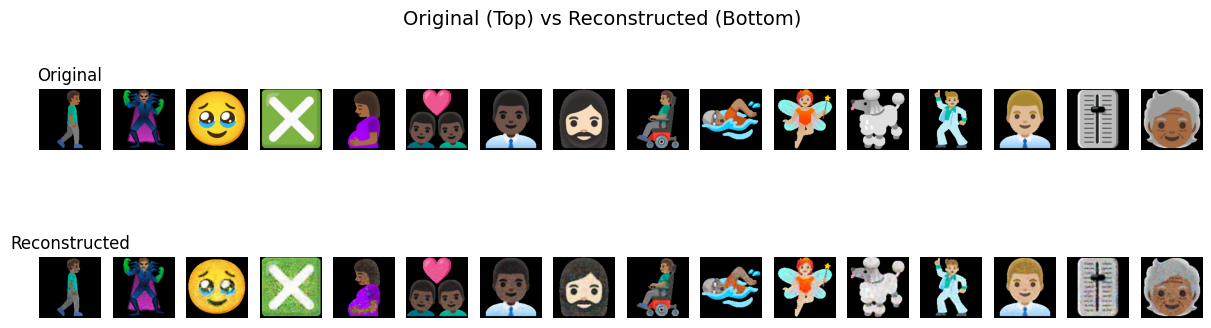

Epoch [240/300] | Train Loss: 6.2608 | Recon Loss: 398223.4738 | KL Loss: 2596.5090


Epoch 241/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.62it/s]


Epoch [241/300] | Train Loss: 6.0500 | Recon Loss: 398131.7797 | KL Loss: 2403.0710


Epoch 242/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.50it/s]


Epoch [242/300] | Train Loss: 6.5878 | Recon Loss: 398252.8302 | KL Loss: 2780.1040


Epoch 243/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.76it/s]


Epoch [243/300] | Train Loss: 6.5941 | Recon Loss: 397945.7415 | KL Loss: 2599.6506


Epoch 244/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.53it/s]


Epoch [244/300] | Train Loss: 5.9988 | Recon Loss: 398244.0418 | KL Loss: 2560.4199


Epoch 245/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.67it/s]


Epoch [245/300] | Train Loss: 6.1988 | Recon Loss: 398005.6380 | KL Loss: 2589.8945


Epoch 246/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.73it/s]


Epoch [246/300] | Train Loss: 5.5392 | Recon Loss: 397492.8538 | KL Loss: 2493.3003


Epoch 247/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.57it/s]


Epoch [247/300] | Train Loss: 6.3743 | Recon Loss: 398171.6766 | KL Loss: 2659.9360


Epoch 248/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.60it/s]


Epoch [248/300] | Train Loss: 6.6670 | Recon Loss: 398322.4989 | KL Loss: 2268.5544


Epoch 249/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.59it/s]


Epoch [249/300] | Train Loss: 6.0774 | Recon Loss: 398112.4068 | KL Loss: 2560.2437


Epoch 250/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.80it/s]


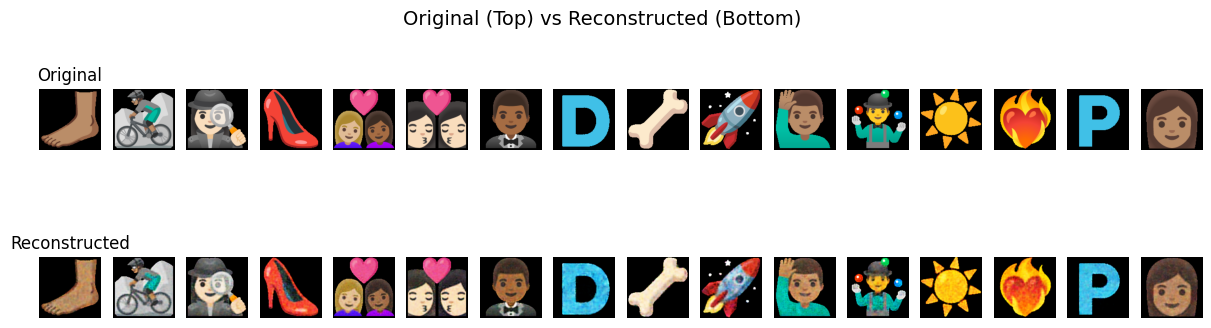

Epoch [250/300] | Train Loss: 5.9787 | Recon Loss: 398364.9648 | KL Loss: 2295.2739


Epoch 251/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.65it/s]


Epoch [251/300] | Train Loss: 6.5418 | Recon Loss: 398101.5087 | KL Loss: 2429.2073


Epoch 252/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.84it/s]


Epoch [252/300] | Train Loss: 5.7966 | Recon Loss: 398000.1136 | KL Loss: 2419.1907


Epoch 253/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.65it/s]


Epoch [253/300] | Train Loss: 6.5951 | Recon Loss: 397888.9722 | KL Loss: 2618.0073


Epoch 254/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.64it/s]


Epoch [254/300] | Train Loss: 6.3828 | Recon Loss: 398231.1811 | KL Loss: 2489.6282


Epoch 255/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.59it/s]


Epoch [255/300] | Train Loss: 6.2407 | Recon Loss: 397694.5967 | KL Loss: 2290.9211


Epoch 256/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.67it/s]


Epoch [256/300] | Train Loss: 6.4556 | Recon Loss: 397870.7209 | KL Loss: 2791.1472


Epoch 257/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.70it/s]


Epoch [257/300] | Train Loss: 6.4286 | Recon Loss: 397782.1298 | KL Loss: 2156.5820


Epoch 258/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.58it/s]


Epoch [258/300] | Train Loss: 6.1259 | Recon Loss: 397493.0127 | KL Loss: 2505.7478


Epoch 259/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.63it/s]


Epoch [259/300] | Train Loss: 6.6491 | Recon Loss: 397784.4102 | KL Loss: 2580.0305


Epoch 260/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.59it/s]


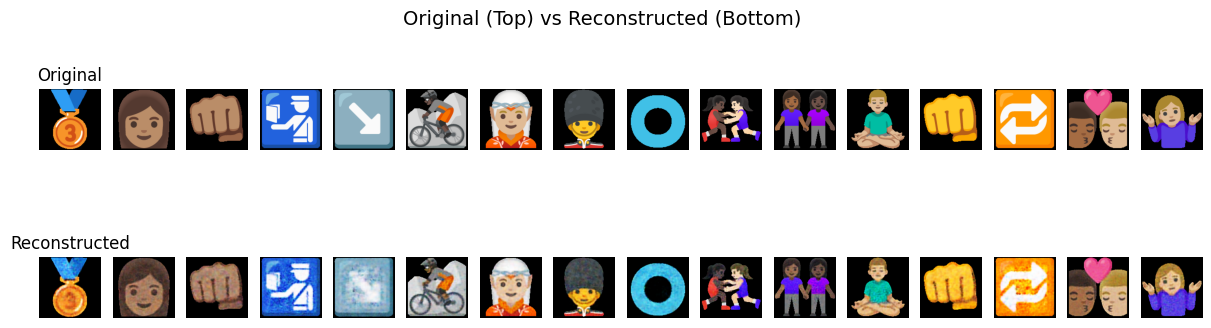

Epoch [260/300] | Train Loss: 6.0546 | Recon Loss: 398165.5207 | KL Loss: 2677.4216


Epoch 261/300 Training: 100%|██████████| 118/118 [00:08<00:00, 13.51it/s]


Epoch [261/300] | Train Loss: 5.9606 | Recon Loss: 398093.3594 | KL Loss: 2627.5493


Epoch 262/300 Training:  54%|█████▍    | 64/118 [00:04<00:03, 13.52it/s]


KeyboardInterrupt: 

In [14]:
total_epochs = 300
target_beta = 1.0
FREEZE_EPOCHS = 3
train_losses = [] 

for epoch in range(1, total_epochs + 1):
    recon_loss, kl_loss, train_loss = train(model, loader, optimizer, device,
                       epoch, total_epochs, target_beta, FREEZE_EPOCHS)

    if epoch % 10 == 0:
        generated_images = generate_orig_vs_recons(model, loader, device, num_samples=16)

    train_losses.append(train_loss)

    print(f"Epoch [{epoch}/{total_epochs}] | Train Loss: {train_loss:.4f} | Recon Loss: {recon_loss:.4f} | KL Loss: {kl_loss:.4f}")


In [16]:
torch.save({
    "model_state_dict": model.state_dict(),
}, "trained_models/vae_model_300.pth")


In [ ]:
# model.eval()
# all_mu = []
# all_logvar = []
# all_z = []
# all_labels = []

# with torch.no_grad():
#     for x in loader:
#         x = x.to(device)
#         mu, logvar = model.encode(x)
#         z = model.reparametrize(mu, logvar)
#         x_hat = model.decoder(z)

#         all_mu.append(mu.cpu())
#         all_logvar.append(logvar.cpu())
#         all_z.append(z.cpu())
#         all_labels.append(y)

# #concat batches
# mu = torch.cat(all_mu)
# logvar = torch.cat(all_logvar)
# z = torch.cat(all_z)
# labels = torch.cat(all_labels)

# #plot
# plt.figure(figsize=(8,6))
# scatter = plt.scatter(z[:, 0], z[:, 1], c=labels, cmap='tab10', s=5)
# plt.colorbar(scatter, label='Class label')
# plt.xlabel("z[0]")
# plt.ylabel("z[1]")
# plt.title("Latent Space Visualization")
# plt.show()


In [17]:
model.eval()

all_z = []
all_x = []

with torch.no_grad():
    for x in loader:
        x = x.to(device)

        mu, logvar = model.encode(x)
        z = model.reparametrize(mu, logvar)

        all_z.append(z.cpu())
        all_x.append(x.cpu())

# Concatenate all batches
all_z = torch.cat(all_z)
all_x = torch.cat(all_x)

# Limit to at most 300 samples for readability
num_samples = min(300, all_z.shape[0])
indices = torch.randperm(all_z.shape[0])[:num_samples]

z_np = all_z.numpy()

# Reduce to 2D
z_2d = TSNE(n_components=2, perplexity=30, learning_rate=200).fit_transform(z_np)

# Convert to tensor for plotting
z_plot = torch.tensor(z_2d)[indices]   # same indices used to subsample x
x_plot = all_x[indices]

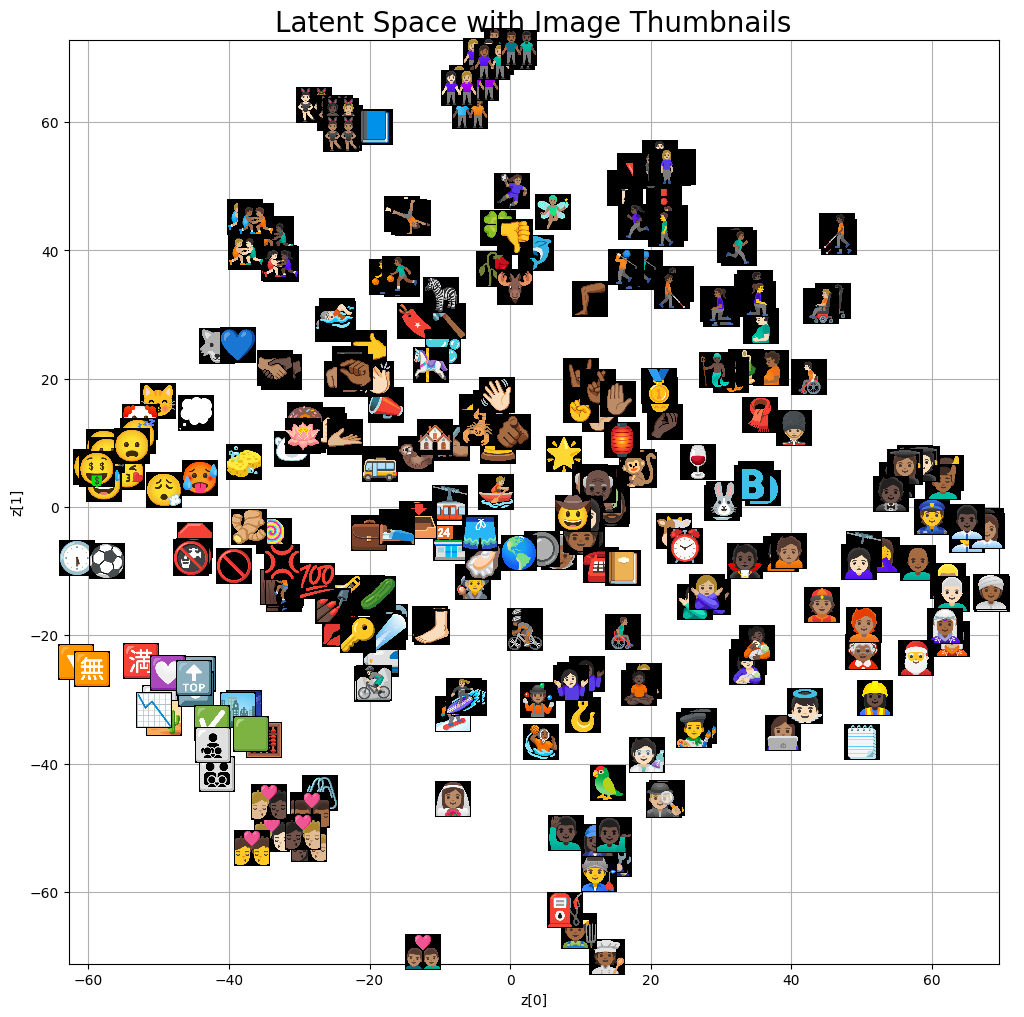

In [18]:
fig, ax = plt.subplots(figsize=(12, 12))

for i in range(num_samples):
    img = x_plot[i].permute(1,2,0).numpy()
    img = np.clip(img, 0, 1)

    ab = AnnotationBbox(
        OffsetImage(img, zoom=0.2),    
        (z_plot[i, 0].item(), z_plot[i, 1].item()),
        frameon=False
    )
    ax.add_artist(ab)

# Expand axis limits  
ax.set_xlim(z_plot[:,0].min() - 1, z_plot[:,0].max() + 1)
ax.set_ylim(z_plot[:,1].min() - 1, z_plot[:,1].max() + 1)

ax.set_title("Latent Space with Image Thumbnails", fontsize=20)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.grid(True)
plt.show()